# Projekt: Optimal opsætning af solpaneler

In [2]:
# RUN THIS LINE IN TERMINAL:
# pip install numpy sympy matplotlib pandas pvlib scipy

import numpy as np
import sympy
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
import scipy

## Indledning

> En husejer nær DTU ønsker at opsætte solpaneler på sit parcelhus med fladt tag. Han tænker han skal vende dem mod syd, men er i tvivl om hvilken vinkel panelet bør danne med taget. I dette projekt skal I finde den optimale vinkel for husejerens solpaneler. Projektets mål er at udvikle en model og et Python-program der for angivet placering på jorden (længde- og breddegrad) kan udregne den optimale vinkel for opsætning af solpaneler under en række simplificerende antagelser. Til simulering skal bruges data fra kalenderåret 2024. I starter med at modellere solens bevægelse på himlen ved hjælp af Python-pakken *[pvlib](https://pvlib-python.readthedocs.io/en/stable/index.html)*. I skal herefter opstille en model for solpanelets energiproduktion, der ikke tager højde for skyer og atmosfære. Solen modelleres som en vektorfelt af parallelle vektorer. For at udregne energiproduktionen skal I kunne integrere vektorfeltets flux gennem solpanelfladen. Vi antager først at panelet er fladt, men I skal efterfølgende generalisere jeres model. En mulighed generalisering er følgende: Find en passende flade i bymiljøet omkring DTU, som kan udstyres med tynde, fleksible solpanelsfilm (som https://www.youtube.com/watch?v=TS9ADU0oc50) og udregn energiproduktionen fra sådanne løsninger.

### Forberedelse

- Ortogonale projektioner, Afsnit 2.3 
- Sfæriske koordinater (Eksempel 6.6.1) og det horisontale koordinatsystem (https://en.wikipedia.org/wiki/Horizontal_coordinate_system) 
- Flader og normalvektor, Afsnit 7.1
- Vektorfelter og flux, Afsnit 7.2 og 7.5

## Om projektet

### Projektmål

Det overordnede mål med projektet at lave et Python-program der for angivet placering på jorden (længde- og breddegrad) kan udregne den optimale vinkel for solpaneler.

### Optimalitet

Optimal kan her betyde mange ting:

- Størst årligt energiproduktion. Det er dette optimalitets mål vi bruger med mindre andet opgives. 
- Krav om en vis daglig minimumslevering (fx om vinteren).
- Laveste samlede energiomkostninger for boligen. Her skal medregnes forbrugskurver, salg af energi til elnettet, en eventuel elbil, m.m.
- Osv.

### Teori: Model og Antagelser

Solenergi er omdannelsen af ​​energi fra sollys til elektricitet ved hjælp af solceller (photovoltaic (PV) cells). Solpanelers produktion af strøm afhænger af anlæggets størrelse (antallet af paneler), panelernes individuelle effektivitet, panelernes placering og selvfølgelig vejrforhold. 

Solindstråling eller irradians (solar irradiance) er den effekt pr. arealenhed (overfladeeffekttæthed) som modtages fra solen i form af elektromagnetisk stråling i måleinstrumentets bølgelængdeområde. Solindstråling måles i watt pr. kvadratmeter (\text{W/m}^2$) i SI-enheder. Solens indstråling har forskellig bølgelængde, fx UV-stråling, der samlet kaldes indstrålingens spektrum. 

Den *gennemsnitlige* årlige solstråling, der ankommer til toppen af ​​jordens atmosfære, er omkring $1361 \text{W/m}^2$. Når solens stråler har passeret atmosfæren, er den samlede stråling (irradians) i Danmark ca. $S_0 := 1100 W/m^2$ på en klar dag midt på dagen. Spektrummet ændres ligeledes gennem atmosfæren, fx kommer den korteste UV-stråling (under 280 nanometer) sjældent ned til Jordens overflade, men vi vil ignore sådanne spektrale ændringer.  

Man kan med god tilnærmelse regne med en lineær sammenhæng mellem solens indstråling og den strømstyrke solpanelet leverer, og vi vil bruge denne tilnærmelse. Da temperaturen i praksis stiger ved øget indstråling, og spændingen falder med øget temperatur, vil effekten dog ikke stige helt lineært. Solens stråler modelleres som et vektorfelt $\pmb{V}_S$ af parallelle vektorer af længde $S_0$. Lad os antage at solpanelet er beskrevet ved en flade $\mathcal{F} = \pmb{r}(\Gamma)$, hvor $\pmb{r} : \Gamma \to \mathbb{R}^2$, $\Gamma = [a_1,b_1] \times [a_2,b_2]$, er en parametrisering af fladen. Energiproduktionen for en solcelle afhænger af vinklen mellem fladens normalvektor $\pmb{n}_\mathcal{F}$ og solstrålerne. Hvis solstrålerne er parallelle med normalvektoren er solens effekt maksimal, mens hvis solstrålerne er vinkelrette på normalvektoren er effekten nul. Solens effekt pr areal i punktet $\pmb{r}(u,v)$, hvor $(u,v) \in \Gamma$, er projektionen af solens stråler ind på fladens enheds normalvektor:

\begin{equation*}
   \left\langle \pmb{V}, \frac{\pmb{n}_\mathcal{F}(u,v)}{\Vert \pmb{n}_\mathcal{F}(u,v) \Vert} \right\rangle 
\end{equation*}

Den samlede effekt fås at integrere denne størrelse op over held fladen, hvilet svarer til fluxen af $V$ gennem fladen $\mathcal{F}$:

\begin{equation*}
   \int_{\Gamma} \langle \pmb{V}, \pmb{n}_\mathcal{F}(u,v) \rangle \mathrm{d}(u,v) 
\end{equation*}

Hvis $\langle \pmb{V}, \pmb{n}_\mathcal{F}(u,v) \rangle < 0$ betyder det er solen lyser på bagsiden af solpanelet, og effekten skal derfor sættes til nul (effekten kan aldrig blive negativ).

Vi angiver her vores **standard-antagelser**, som bruges med mindre andet angives:   

- Panelet er fladt og fastmonteret
- Vi antager at den maksimale irradians/indstråling fra solen på solpanelet er $S_0 = 1100 W/m^2$. Alle vektorer i solens vektorfelt $\pmb{V}: \mathbb{R}^3 \to \mathbb{R}^3$ er parallelle og har længden $S_0$. 
- Solpanelets effekt afhænger lineært af solindstrålingen og fluxen af solens vektorfelt gennem solpanelets (over)flade.  
- Solpanelet effektivitet: Ved en flux på 1000 W per $m^2$ leverer panelet $Wp/(L B)$ per $m^2$, hvor $Wp$ er panelets peak power watts (STC), $L$ er længden og $B$ er bredden. 
- Skydækket og andre atmosfæriske forstyrrelser modelleres ikke, men fastsættes til en gennemsnitlig værdi: vi antager at disse forstyrrelser halverer solens energi gennem hele året: $S_0 A_0 = 550 W/m^2$, hvor faktoren er $A_0 = 0.5

Der vil i sidste del af projektet være mulighed for at vende tilbage til disse antagelser og undersøge om/hvordan de kan erstattes af bedre antagelser.

## Indledende øvelser

> Find via litteratur-søgning den anbefalede vinkel man opstiller solpaneler ved i Danmark. Vinklen siges at være er nul grader hvis panelet ligger fladt ned på jorden (eller taget).

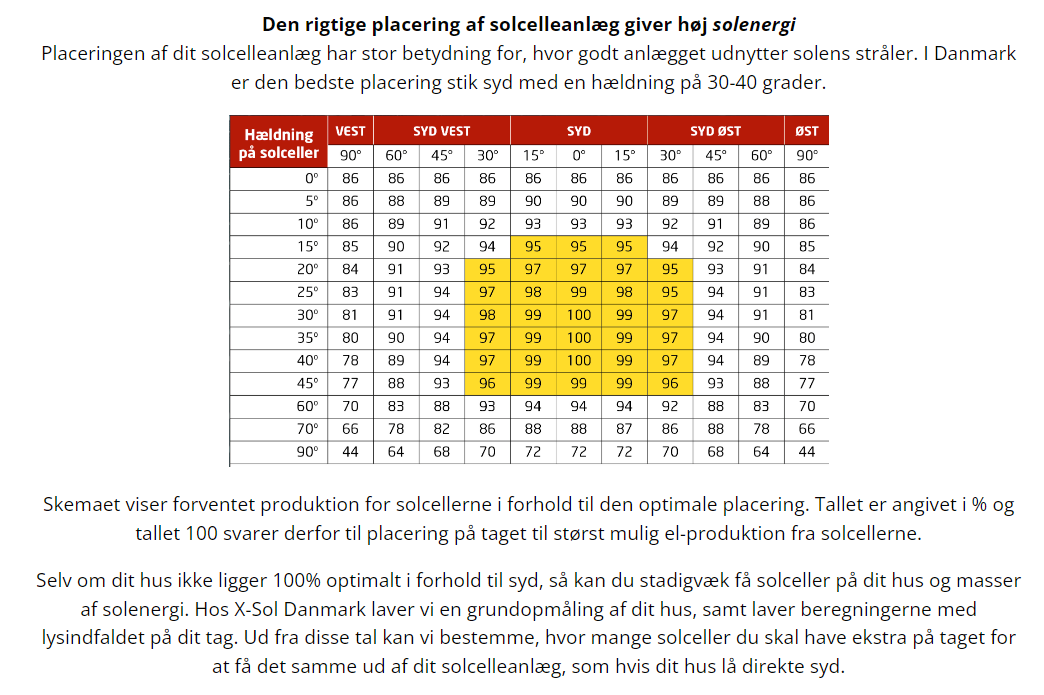
"LINK: https://www.x-sol.dk/solceller-placering.html"

> Udvælg en solpanelstype. I kan søge på montører i Danmark og undersøge hvilke paneler de typisk bruger, eller I kan google "solar panel datasheet" eller lignende. Solpanelet bør være et standard panel (der er fladt og altså ikke fx krummer). Find et datablad for det valgte solpanel, og beskriv panelets størrelse (anvend $L$ længde og $B$ for bredde) og angiv Wp/Pmax (kaldet max power, peak power watts eller lignende) under standarden STC. Beskriv hvad standarden STC beskriver. Udregn $Wp/(L B)$ (jvf. listen af standard-antagelser ovenfor). Antag ideelle forhold: solen står vinkelret på solpanelet og solens irradians er $1100 W/m^2$ igennem en hel time. Hvor mange J og kWh leverer panelet på denne time? Hvor mange Wh er dette per $m^2$? 

link til datasheet: http://www.solarelectricuk.com/high-power-pv-solar-panels/data-sheets.html

MODEL VALGT: STKP- 60 – 250

Panelets længde L: 1673 mm

Panelets Bredde B: 991 mm

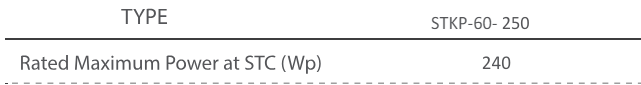

Beskrivelse af STC: STC står for Standard Test Condition. Det er en slut-test som producenten udfører hvor solpanelet udsættes for en indstråling på $1000 \frac{W}{m^2}$ med en omgivelsestemperatur på 25 grader og en luftmasse på 1,5. Disse betingelser er beregnet til at repræssentere en typisk solrig dag i moderate klimaer. 
Watt Peak (WP) er den maksimale effekt, som et solpanel kan producere under de overnævnte betingelser. STC Testens formål er at måle solpanellets maksimale udgangseffekt. 

In [4]:
# L: 1673 mm to m
L = 1673 / 1000

# B: 991 mm to m
B = 991 / 1000

# Maximum power (STC)
W_p = 240

Areal = L * B

# Calculate
W_p_LB = W_p / Areal

display(W_p_LB)

144.75769070468647

In [15]:
W_p_LB_1100 = W_p_LB * 1.1

Watt = W_p_LB * Areal

# joules for whole area
time = 60 * 60
watt_pr_H = Watt * time
display(watt_pr_H)

# joules to kwH
result_KWH = watt_pr_H / 1000
display(result_KWH)

# wH for only m^2
result_wH_m2 = watt_pr_H / Areal
display(result_wH_m2)


1045440.0000000001

1045.44

630564.5007096144

> Jeres endelige rapport skal desuden indeholde et indledende afsnit, hvor I beskriver solenergi og solceller. I bestemmer selv hvad afsnittet præcist skal indeholde, men nedenstående kilder kan bruges til at findes information. Det anbefales først at skrive dette afsnit, når I nået længere med projektet. 

1. https://www.pveducation.org/
1. https://www.acs.org/education/resources/highschool/chemmatters/past-issues/archive-2013-2014/how-a-solar-cell-works.html

Panelet er fladt, så enhedsnormalvektoren $\pmb{u}_p$ er konstant (og har længde 1) hvor:

\begin{equation*}
\pmb{u}_p = \frac{\pmb{n}_{\mathcal{F}}(u,v)}{\Vert \pmb{n}_\mathcal{F}(u,v) \Vert}
\end{equation*}

> Angiv en formel eller udtryk for fluxen gennem fladen udtrykt ved $A_0$, $\pmb{u}_p, \pmb{V}, L$ og $B$. Vi definerer fluxen til at være nul hvis vinklen mellem $\pmb{u}_p$ og $\pmb{V}$ er større end $\pi/2$ (90 grader), da vi ikke ønsker negativ flux. Jeres udtryk skal tage højde for dette.

Hint: Da normalvektoren er konstant, kan I slippe af med integraltegnet.

Fluxen gennem en flade kan generelt beregnes ved at tage dotproduktet af vektorfeltet og normalvektoren til fladen, og derefter integrere over fladen. Men da normalvektoren er konstant i dette tilfælde, kan vi slippe af med integraltegnet. 

Fluxen $\Phi$ kan derfor udtrykkes som:

\begin{equation*}
\Phi = \begin{cases} 
A_0 \cdot \left<\pmb{V}, \pmb{u}_p\right> \cdot L \cdot B & \text{hvis } \left<\pmb{V}, \pmb{u}_p\right> \geq 0 \\
0 & \text{hvis } \left<\pmb{V}, \pmb{u}_p\right> < 0 
\end{cases}
\end{equation*}

Her er $\left<\pmb{V}, \pmb{u}_p\right>$ dotproduktet af enhedsnormalvektoren og solens vektorfelt, hvilket er lig med længden af solens vektorfelt gange cosinus til vinklen mellem de to vektorer. Hvis denne vinkel er større end 90 grader (dvs. $\pmb{u}_p \cdot \pmb{V} < 0$), sætter vi fluxen til at være 0, da vi ikke ønsker negativ flux. $A_0$ er den gennemsnitlige reduktionsfaktor for solens energi på grund af atmosfæriske forstyrrelser, og $L$ og $B$ er længden og bredden af solpanelet.

Fluxen bestemmer den øjeblikkelige effekt for panelet for en bestemt retning af solens stråler $\pmb{V}$ og for en bestemt placering af panelet bestemt ved $\pmb{u}_p$. For at finde den samlede energiproduktion for en solpanel, har vi har derfor brug for at kunne modellere solens bevægelse i forhold til panelet. Dette modeleres med en solspositionsalgoritme (SPA) fra Python-pakken `pvlib`, men inden vi kommer så langt har vi brug at udvikle nogle værktøjer i NumPy.

> Angiv SI-enheder for $\pmb{V}$, $L$, $B$, $A_0$, fluxen, energi. Angiv sammenhængen mellem J og kWh.

$\pmb{V}$ har SI-enheden $\frac{W}{m^2}$

$L$ har SI-enheden $m$

$B$ har SI-enheden $m$

$A_0$ er dimensionsløs

Fluxen har SI-enheden $W$

energi har SI-enheden $J$

## NumPy

I projektet har vi brug for at kunne finde minimum, maksimum og/eller nulpunkter as NumPy-arrays, så vi starter med at blive fortrolige med dette. Vi betragter en simpel funktion $f: [0, 2 \pi] \to \mathbb{R}$ givet ved $f(x) = \cos(x)$ og ønsker at kunne bestemme minimum, maksimum og nulpunkter af denne. Vi vil i projektet dog ikke have selve funktionen eller dens funktionsudtryk, men kun en (lang) række at funktionsværdier, fx $f(t_n)$ for $t_n = 2\pi n/N$ for $n = 0,1, \dots, N-1$. Vi opfatter her $\Delta t_n = 2 \pi/N$ som afstanden mellem vores tids-samples. I NumPy:

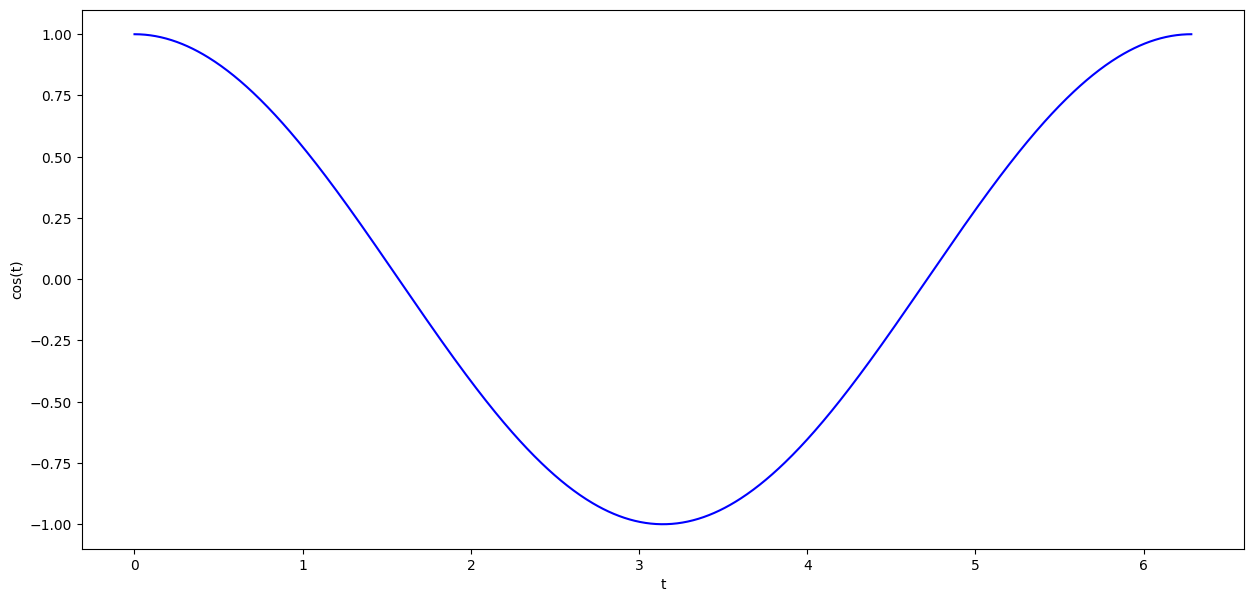

[0.         0.00628947 0.01257895 0.01886842 0.0251579  0.03144737
 0.03773685 0.04402632 0.0503158  0.05660527 0.06289475 0.06918422
 0.0754737  0.08176317 0.08805265 0.09434212 0.1006316  0.10692107
 0.11321055 0.11950002 0.1257895  0.13207897 0.13836845 0.14465792
 0.15094739 0.15723687 0.16352634 0.16981582 0.17610529 0.18239477
 0.18868424 0.19497372 0.20126319 0.20755267 0.21384214 0.22013162
 0.22642109 0.23271057 0.23900004 0.24528952 0.25157899 0.25786847
 0.26415794 0.27044742 0.27673689 0.28302637 0.28931584 0.29560531
 0.30189479 0.30818426 0.31447374 0.32076321 0.32705269 0.33334216
 0.33963164 0.34592111 0.35221059 0.35850006 0.36478954 0.37107901
 0.37736849 0.38365796 0.38994744 0.39623691 0.40252639 0.40881586
 0.41510534 0.42139481 0.42768429 0.43397376 0.44026323 0.44655271
 0.45284218 0.45913166 0.46542113 0.47171061 0.47800008 0.48428956
 0.49057903 0.49686851 0.50315798 0.50944746 0.51573693 0.52202641
 0.52831588 0.53460536 0.54089483 0.54718431 0.55347378 0.5597

In [18]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
figurstr = (15, 7)

t = np.linspace(0, 2 * np.pi, 1000)
f = np.cos(t)

plt.figure(figsize=figurstr)
plt.plot(t, f, color='b', linestyle='-')
plt.xlabel('t')
plt.ylabel('cos(t)')
plt.show()

print(t,f)  # uncomment to see the values of t and f

Vi opfatter `t` og `f` som *vektorer* af hhv variabel- og funktionsværdier. NumPy har mange indbyggede metoder, der kan være nyttige, fx

In [2]:
f.max(), f.min(), f.argmax(), f.argmin(), t[f.argmax()], t[f.argmin()]

(1.0, -0.9999950553174459, 0, 499, 0.0, 3.138447916198812)

Man kan også spørge hvilke funktionsværdier der fx er mindre end $-0.95$:

In [3]:
idx = f < -0.95
f[idx], t[idx]

# Or in one line
f[f < -0.95], t[f < -0.95]

(array([-0.95192731, -0.95383508, -0.95570513, -0.95753737, -0.95933173,
        -0.96108814, -0.96280654, -0.96448685, -0.96612901, -0.96773295,
        -0.96929861, -0.97082592, -0.97231483, -0.97376528, -0.97517722,
        -0.97655057, -0.9778853 , -0.97918134, -0.98043865, -0.98165717,
        -0.98283687, -0.98397768, -0.98507957, -0.9861425 , -0.98716641,
        -0.98815128, -0.98909706, -0.99000371, -0.9908712 , -0.99169949,
        -0.99248855, -0.99323836, -0.99394887, -0.99462007, -0.99525192,
        -0.9958444 , -0.99639749, -0.99691116, -0.9973854 , -0.99782019,
        -0.9982155 , -0.99857133, -0.99888765, -0.99916446, -0.99940175,
        -0.99959951, -0.99975772, -0.99987639, -0.9999555 , -0.99999506,
        -0.99999506, -0.9999555 , -0.99987639, -0.99975772, -0.99959951,
        -0.99940175, -0.99916446, -0.99888765, -0.99857133, -0.9982155 ,
        -0.99782019, -0.9973854 , -0.99691116, -0.99639749, -0.9958444 ,
        -0.99525192, -0.99462007, -0.99394887, -0.9

hvor vi også angiver de tilhørende tids-værdier i `t`-vektoren.

> Skriv Python-kode der finder alle funktionsværdier i `f` i intervallet $[-0.05, 0.05]$ og angiver de tilhørende `t`-værdier. 

> Skriv en Python-funktion der kan findes begge fortegnsskift (nulpunkterne) af `f`. 

Tjek at de fundne nulpunkter stemmer rimeligt overens med de eksakte nulpunkter for $f$. Jeres metode bør være simpel og også virke på "vektorer" `np.array([3, 0.5, 0.1,-0.5, -1, -0.5, 0.5, 2])` hvor vi ikke kender den funktion, der ligger bag funktionsværdierne. Specielt bør jeres metode ikke bruge anden viden om $\cos$ (fx at den kan differentieres) end den information I har i `f`-vektoren.  

I kan finde inspiration i bisektionsmetoden (som I stødte på i Matematik 1a i efteråret), eller I kan finde inspiration i NumPy-funktioner `np.where, np.diff, np.sign` eller følgende Python-plot:

In [24]:
f_values = f[np.logical_and(-0.05 <= f, f <= 0.05)]
t_values = t[np.logical_and(-0.05 <= f, f <= 0.05)]

f_values, t_values

(array([ 0.04872413,  0.0424412 ,  0.0361566 ,  0.02987056,  0.02358334,
         0.01729519,  0.01100636,  0.00471709, -0.00157237, -0.00786176,
        -0.01415085, -0.02043937, -0.02672708, -0.03301374, -0.03929909,
        -0.04558289, -0.04558289, -0.03929909, -0.03301374, -0.02672708,
        -0.02043937, -0.01415085, -0.00786176, -0.00157237,  0.00471709,
         0.01100636,  0.01729519,  0.02358334,  0.02987056,  0.0361566 ,
         0.0424412 ,  0.04872413]),
 array([1.5220529 , 1.52834237, 1.53463185, 1.54092132, 1.5472108 ,
        1.55350027, 1.55978975, 1.56607922, 1.5723687 , 1.57865817,
        1.58494765, 1.59123712, 1.59752659, 1.60381607, 1.61010554,
        1.61639502, 4.66679029, 4.67307976, 4.67936924, 4.68565871,
        4.69194819, 4.69823766, 4.70452714, 4.71081661, 4.71710609,
        4.72339556, 4.72968504, 4.73597451, 4.74226399, 4.74855346,
        4.75484294, 4.76113241]))

In [28]:
# B

for i in range(len(f_values)-1):
    if i > 0:
        if f_values[i-1] > 0 & f_values[i] < 0:
            print("Fortegn skift")
        if f_values[i-1] < 0 & f_values[i] > 0:
            print("Fortegn skift")
    print(f_values[i])


0.04872413008921228


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

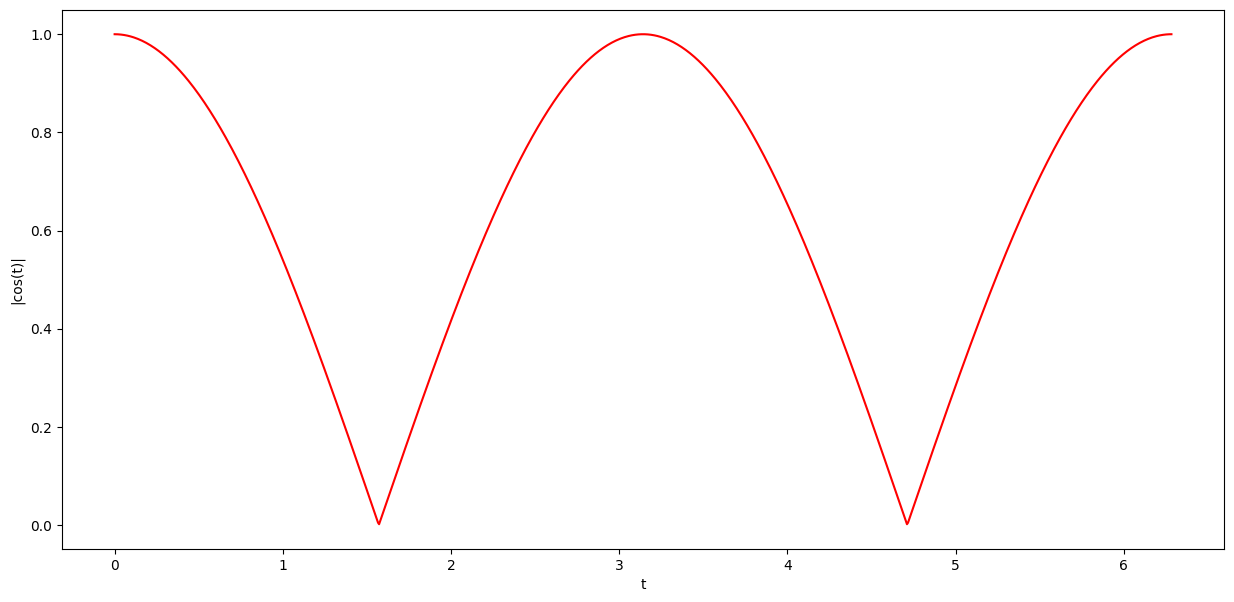

In [4]:
plt.figure(figsize=figurstr)
plt.plot(t, np.abs(f), color="r")  # linestyle='-', marker='.'
plt.xlabel("t")
plt.ylabel("|cos(t)|")
plt.show()

## Solspositionsmodel

### Koordinatsystem

For at kunne regne på fx solens bevægelse og projektionen af solens stråler ind på panelets normalvektor, skal vi have indført (mindst et) passende koordinatsystem. Vi vælger at placere et fast centrum (origo) $(0,0,0)$ i panelets position. Vi forestiller os herefter tangentplanen til jorden i panelets position. Normalvektoren til dette tangentplan vil være vores $z$-akse. $x$-aksen og $y$-aksen "udspænder" således tangentplanen. Vi fastlægger koordinatsystemet ved at $x$-aksen peger mod nord og $y$-aksen mod øst. Den opmærksomme læser vil have opdaget at dette er et venstredrejet koordinatsystem. Dette er dog traditionen, og koordinatsystemet kaldes det horisontale koordinatsystem https://en.wikipedia.org/wiki/Horizontal_coordinate_system. Vi har altså nu et referencesolpositionssystem, der fokuserer på observatøren (panelet) på en given bredde- og længdegrad på jordens overflade. Lad os opsummere:

1. Koordinatsystemet har centrum i solpanelet (kaldet observatøren). Det er traditionelt at bruge et ventredrejet koordinatsystem hvor $x$-aksen peger mod nord, $y$-aksen peger med øst og $z$-aksen peger mod zenit-punktet i retning af normalvektoren til tangentplanen. Koordinatsystemet kaldes det horisontale koordinatsystem, da det er orienteret efter observatørens lokale horisont. 
1. Ethvert objekt kan beskrives i det horisontale koordinatsystem enten i kartesiske koordinater $(x,y,z)$ eller sfæriske koordinater $(r,\theta,\phi)$. Her er $\phi \in [0,2\pi]$ azimut-vinklen der måles fra $x$-aksen mod $y$-aksen, $\theta \in [0,\pi]$ er zenit-vinklen fra $z$-aksen og $r$ er radius.  
1. Det horisontale koordinatsystem er fastgjort til et sted på Jorden, ikke stjernerne eller solen. Objekter på stjernehimlen forestilles placeret på himmelsfæren i en fast afstand og deres placering beskrives ved azimut- og zenit-vinklen (radius ignoreres således i denne type beskrivelse). Over tiden vil zenit- og azimut-vinklen for et objekt på himlen (som fx solen) ændres, da objektet ser ud til at drive hen over himlen med Jordens rotation. Da det horisontale koordinatsystem er defineret af observatørens lokale *horisont*, vil det samme objekt set fra forskellige steder på Jorden på samme tid have forskellige værdier af azimut- og zenit.

![Kilde: https://assessingsolar.org/notebooks/solar_position.html](solar_position_system.png)


Vi måler enten vinklerne i radianer $(\theta, \phi) \in [0, \pi] \times [0, 2\pi]$ eller grader $(\theta,\phi) \in [0, 180^\circ] \times [0, 360^\circ]$. Der bruges ofte endnu en vinkel, nemlig solens højdevinkel ($\alpha$), som er komplementæren til zenitsolvinklen ($\alpha = 90^\circ - \theta$), der altså måler vinklen fra horisont-planen mod $z$-aksen.

> Skriv en Python-funktion `def solar_elevation_angle(theta)` der givet $\theta$ i grader udregner $\alpha$ i grader.

Hvis vinklerne er givet i radianer, kan vi bruge `solar_elevation_angle` sammen med `np.deg2rad` og `np.rad2deg`. Vi behøver derfor ikke lave funktioner for både grader og radianer, da vi let kan genbruge vores funktioner. Hvis vi fx her ønsker at regne i radianer:

In [5]:
theta_in_rad = np.pi / 3  # zenit-vinkel givet i radianer
print(np.pi / 2. - theta_in_rad)  # højdevinkel givet i radianer
# højdevinkel givet i radianer
# np.deg2rad(solar_elevation_angle(np.rad2deg(theta_in_rad)))  # udkommenter denne

0.5235987755982989


Det anbefales i det videre forløb at regne i radianer, men at angive resultater/vikler i grader hvis dette er mere sigende/beskrivende. Bemærk også at vi ikke behøver at bruge `solar_elevation_angle` i det følgende da både zenit- og elevationsvinklen vil være tilgængelige.

I det horisontale koordinatsystem er ethvert objekt på *himmelsfæren* fuldstændig bestemt af zenitvinklen ($\theta$) og azimutvinklen $\phi$. Som nævnt ignorer man den radiale koordinat når alle objekter placeres på himmelsfæren. Vi kan dog sagtens medtage den radiale koordinat: 

> Antag at solen har en fast afstand $r_s$ til jorden. Find en rimelig værdi for $r_s$. Angiv et (matematisk) udtryk for hvordan solens $xyz$-koordinat kan udregnes ud fra $r_s$, $\theta_s$ og $\phi_s$, hvor $\theta_s$ og $\phi_s$ er hhv. zenit og azimut-vinklen for solens placering.

Der placeres et (flat) solpanel i origo af koordinatsystemet. Enhedsnormalen $\pmb{u}_p \in \mathbb{R}^3$ til solpanelet har zenit-vinkel $\theta_p$ og azimut-vinkel $\phi_p$. Vi betrager en normaliseret (dvs enheds-) solvektor $\pmb{u}_{s} \in \mathbb{R}^3$ givet ved $(\theta_s, \phi_s)$. Solens vektorfelt er således givet ved $\pmb{V} = S_0 \pmb{u}_{s}$.  

> Angiv et (matematisk) udtryk for $\pmb{u}_p$ og for $\langle \pmb{u}_{s}, \pmb{u}_p \rangle$ ud fra zenit- og azimut-vinklerne. I bør simplificere udtrykket så det indeholder $\cos(\theta_p-\theta_s)$ og kun 5 trigonometriske funktioner.  Vis at $-1 \le \langle \pmb{n}_{u}, \pmb{u}_p \rangle \le 1$. Forklar man egne ord hvad det betyder når $\langle \pmb{u}_{s}, \pmb{u}_p \rangle < 0$.

> Skriv en Python-funktion `def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel)` der returnerer $\langle \pmb{n}_{s}, \pmb{n}_p \rangle$ når det er positivt og ellers returnerer nul. 

> Kig igen på jeres Python-funktion `def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel)`. Skriv den om så den virker på NumPy-arrays af zenit- og azimut-vinkler. Du kan teste den på følgende de tre situationer, hvor projektionen bør give 0.707107, 0.0 og 0.0 (eller rettere, med numeriske fejl, bør det give `array([7.07106781e-01, 6.12323400e-17, 0.0])`). Forklar solpanelets orientering og solens placering i de tre situationer.

In [6]:
theta_sol = np.array([np.pi / 4, np.pi / 2, 0.0])
phi_sol = np.array([np.pi, np.pi / 2, 0.0])
theta_panel = np.array([0.0, np.pi / 2, np.pi])
phi_panel = np.array([np.pi, 0.0, 0.0])

# solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel)

### Solpositionsmodellering ved Pvlib

I Python kan solpositionsvinklerne, benævnt $(\theta_s, \phi_s)$, nemt beregnes på ethvert sted ved hjælp af solar positionsalgoritmen (SPA) med pakken `pvlib`, der som standard er implementeret med National Renewable Energy Laboratory's SPA-algoritme [Reda og Andreas, 2003, https://www.nrel.gov/docs/fy08osti/34302.pdf]). Vi følger https://assessingsolar.org/notebooks/solar_position.html.

In [7]:
import pandas as pd
import pvlib
from pvlib.location import Location

Vi skal først have defineret observatørens/panelets geografiske placering. Det gøres via objektet *pvlib.location.Location* i biblioteket *[pvlib](https://pvlib-python.readthedocs.io/en/stable/index.html)*, hvor vi skal angive bl.a. breddegrad, længdegrad, tidszone og højde. Til simulering bruges data for $(\theta_s, \phi_s)$ fra fx kalenderåret 2024, men her i denne indledende øvelse nøjes vi med data for nuværende måned, april 2024:

In [8]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-04-01"
slut_dato = "2024-04-30"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.660439, 12.604980, tidszone, 10, "Amager (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
)

> Vælg placering/lokation for jeres solpanel, fx DTU. Ret overstående GPS koordinater (målt i DecimalDegrees), højde og navn så det passer med den valgte lokation. 

Vi kan nu finde solpositionen ud fra det horisontale koordinatsystem placering i `site` for det angivne tidsinterval ved følgende kald:

In [9]:
# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

# Visualize the resulting DataFrame
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2024-04-01 00:00:00+02:00,117.855212,117.855212,-27.855212,-27.855212,339.197342,-3.866396
2024-04-01 00:01:00+02:00,117.904726,117.904726,-27.904726,-27.904726,339.473686,-3.866190
2024-04-01 00:02:00+02:00,117.953602,117.953602,-27.953602,-27.953602,339.750301,-3.865984
2024-04-01 00:03:00+02:00,118.001838,118.001838,-28.001838,-28.001838,340.027184,-3.865777
2024-04-01 00:04:00+02:00,118.049434,118.049434,-28.049434,-28.049434,340.304332,-3.865571


Vi ser at DataFramen indeholder solpositionen for hvert minut i april 2024. Tids-samplingen $\Delta t$ kan styres ved `delta_tid = "Min"` (minute) sat ovenfor. Når vi senere skal udregne energiproduktionen over hele 2024, kan det være tilstrækkeligt med at kende solpositionen for hver time (for hele året 2024), DataFramen bliver nemlig meget stor, hvis man bruger `delta_tid = "Min"` for et helt år. Dette klares ved `delta_tid = "H"` (hour). Bemærk at `delta_tid = "M"` (month) sætter $\Delta t$ til en måned (hvilket er for stort til vores behov).

Efter at solvinklerne er estimeret ved hjælp af `pvlib`, kan de visualiseres, fx for den 1. april:

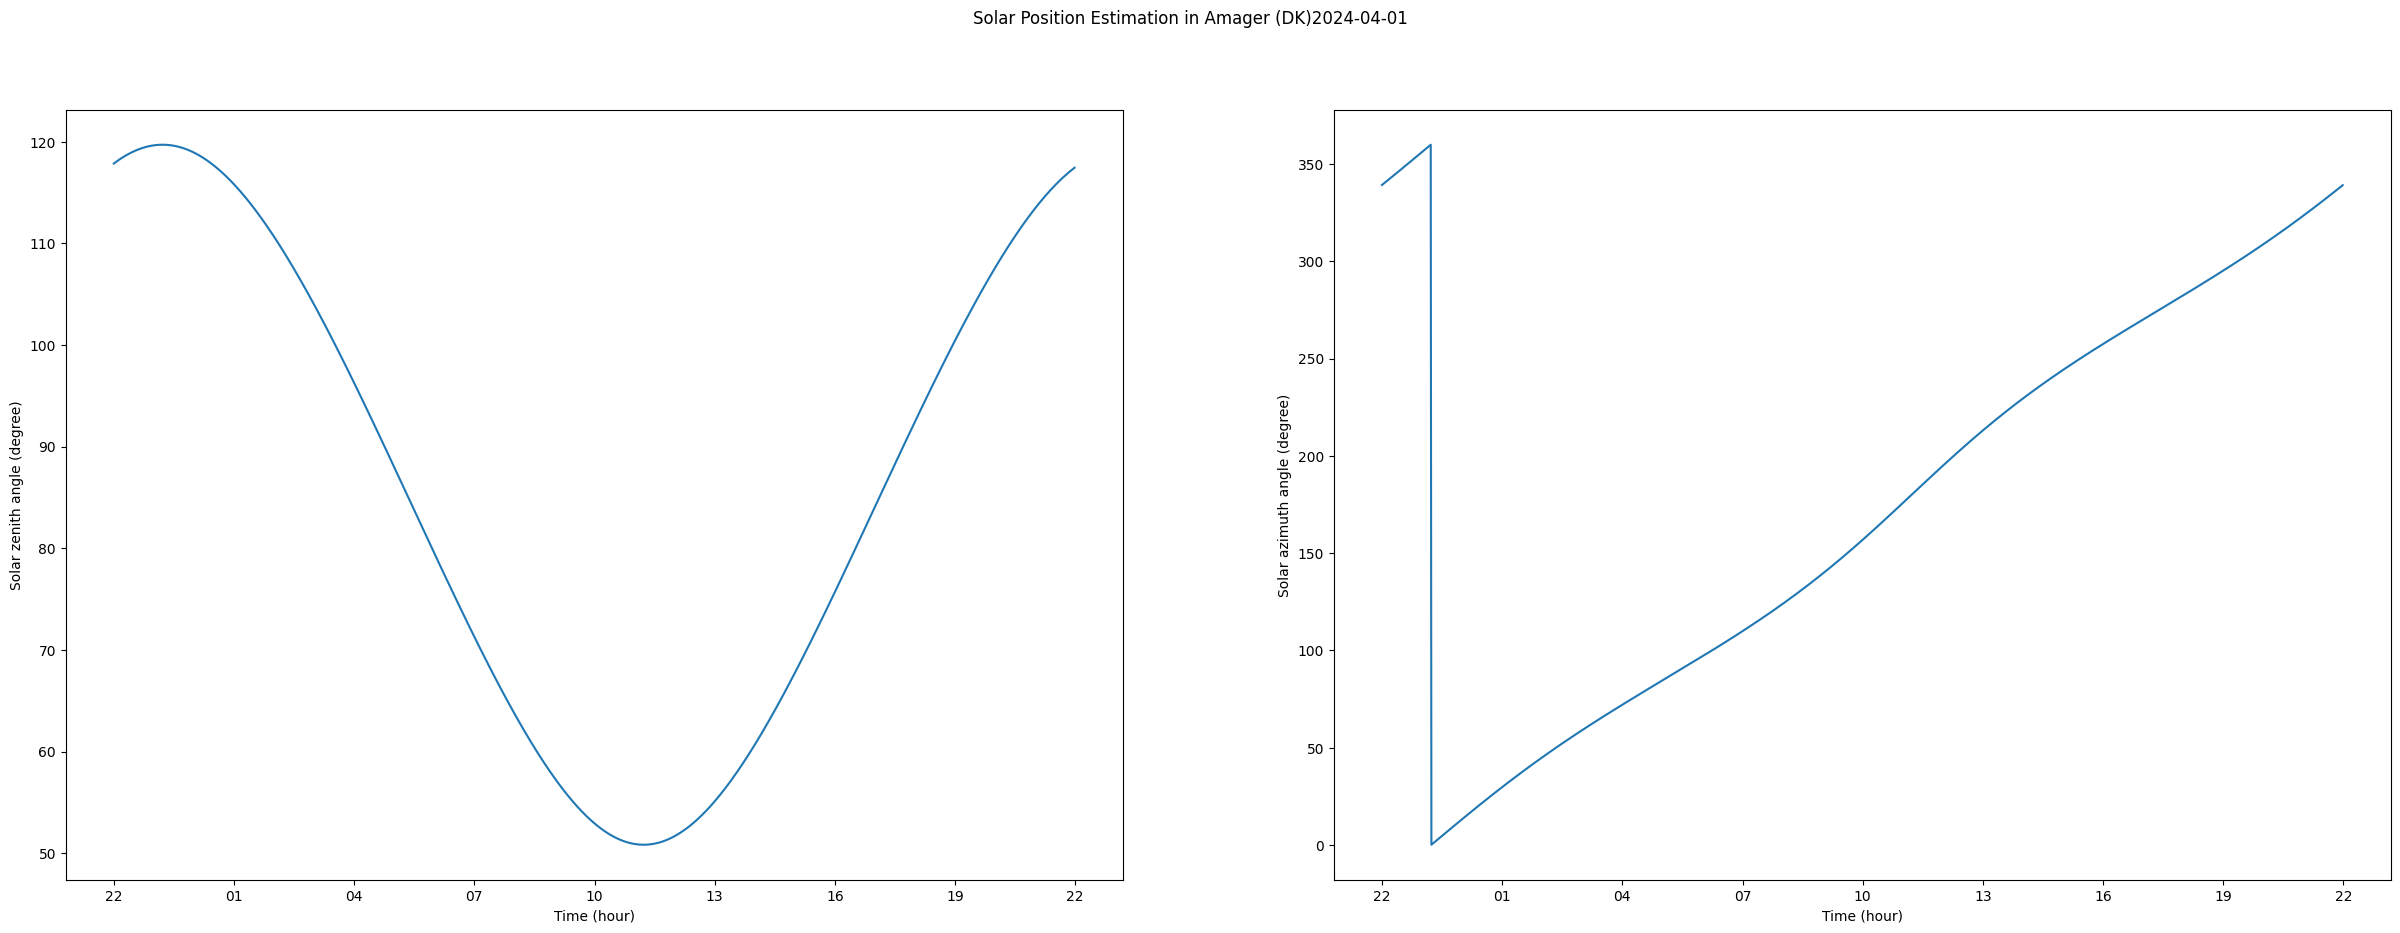

In [10]:
import matplotlib.dates as mdates

valgt_dato = "2024-04-01"

# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle("Solar Position Estimation in " + site.name + valgt_dato)

# plot for solar zenith angle
ax1.plot(solpos.loc[valgt_dato].zenith)
ax1.set_ylabel("Solar zenith angle (degree)")
ax1.set_xlabel("Time (hour)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))

# plot for solar azimuth angle
ax2.plot(solpos.loc[valgt_dato].azimuth)
ax2.set_ylabel("Solar azimuth angle (degree)")
ax2.set_xlabel("Time (hour)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H"))

Bemærk at $x$-aksen bruger UTC-tidszone og der derfor skal $+2$ for at få dansk tid. De plottede vektorer kan udskrives:

In [11]:
valgt_dato = "2024-04-01"
print(solpos.loc[valgt_dato].zenith)
print(solpos.loc[valgt_dato].elevation)
print(solpos.loc[valgt_dato].azimuth)

2024-04-01 00:00:00+02:00    117.855212
2024-04-01 00:01:00+02:00    117.904726
2024-04-01 00:02:00+02:00    117.953602
2024-04-01 00:03:00+02:00    118.001838
2024-04-01 00:04:00+02:00    118.049434
                                ...    
2024-04-01 23:55:00+02:00    117.237633
2024-04-01 23:56:00+02:00    117.289913
2024-04-01 23:57:00+02:00    117.341566
2024-04-01 23:58:00+02:00    117.392590
2024-04-01 23:59:00+02:00    117.442983
Freq: min, Name: zenith, Length: 1440, dtype: float64
2024-04-01 00:00:00+02:00   -27.855212
2024-04-01 00:01:00+02:00   -27.904726
2024-04-01 00:02:00+02:00   -27.953602
2024-04-01 00:03:00+02:00   -28.001838
2024-04-01 00:04:00+02:00   -28.049434
                               ...    
2024-04-01 23:55:00+02:00   -27.237633
2024-04-01 23:56:00+02:00   -27.289913
2024-04-01 23:57:00+02:00   -27.341566
2024-04-01 23:58:00+02:00   -27.392590
2024-04-01 23:59:00+02:00   -27.442983
Freq: min, Name: elevation, Length: 1440, dtype: float64
2024-04-01 00:00:00+

Her har vi valgt at plotte solvinklerne for 1. april. 

> Plot solens zenit-, azimut- og elevationsvinkel, dvs. $\theta_s, \phi_s, \alpha_s$, for hele dagen den 20. april 2024 som funktion af tiden. 

**Anbefaling:** I det følgende har vi brug af at arbejde med vektorer af fx zenit- og azimut-vikler, specielt at kunne finde maksimumsværdier, nulpunkter, integrere, osv. Det anbefales derfor at arbejde med dataen fra `solpos` som NumPy-arrays. Dette kan gøres ved fx:

In [12]:
np.array(solpos.loc[valgt_dato].elevation)

array([-27.85521243, -27.90472593, -27.95360189, ..., -27.34156572,
       -27.39258993, -27.44298348])

> Plot solens elevationsvinkel og find ud af hvornår på dagen solen står højest den 20. april 2024. Forklar hvad det betyder når $\alpha_s < 0$ eller $\theta_s > 90^\circ$.

> Find tidspunktet for solopgang og solnedgang på DTU den 20. april 2024. Sammenlign med "kendte" værdier fx fra DMI. *Hint:* Hvis I ønsker præcise værdier skal I bruge `apparent_elevation` (apparent sun elevation accounting for atmospheric refraction) i stedet for `elevation`. I behøver ikke tage højde for jordens krumning.

> Find solens højeste punkt på himlen (i grader) på sommersolhverv på DTU, og hvornår på dagen det sker? *Hint:* Du bliver nødt til at ændre på start og slut dato for `solpos`-objektet.

> Lav en Python-funktion som kan beregne solens højeste punkt $\alpha_{max}$ på himlen (i grader) på en given dato (year-month-day) i en given lokation (fx by) angivet ved en breddegrad og længdegrad. *Hint:* Svaret bør ikke afhænge af længdegraden, da solens højeste punkt på himlen kun afhænger af breddegraden.

I har i en tidligere opgave fundet et udtryk for solens $xyz$-koordinat ud fra $r_s$, $\theta_s$ og $\phi_s$. 

> Skriv en Python-funktion (til brug med NumPy arrays) der omregner fra solens zenit og azimuth til solens position angivet i $xyz$-koordinaten. Husk om I regner i radianer eller grader. Her kan `np.deg2rad()`-funktionen være nyttig. Det er fint at bruge en cirka værdi for $r_{s}$ men man kan finde en mere korrekt værdi ved: `pvlib.solarposition.nrel_earthsun_distance(times) * 149597870700`, hvor `149597870700` er antal meter på en astronomisk enhed AU.

> Skriv en Python funktion der omregner fra solens position på himlen i et $xyz$ koordinater til zenit og azimuth (i grader eller radianer). Her kan `np.arctan2(y, x)` og `np.rad2deg()` være nyttige.

## Effekt- og energiberegninger

**Anbefaling:** Det anbefales at I regner alting i radianer. Husk at man kan bruge `np.deg2rad` eller `np.rad2deg`. Hvis I har vinklerne i grader, skal man altså bruge `np.rad2deg`.   

Vi betragter den 20. april. `solpos` indeholder solpositionsdata for hver minut gennem hele dagen. Da der er 1440 minutter på en dag er solpositionsvinkler over denne dag beskrevet ved en vektor af denne længde, fx:

In [13]:
solpos.loc[valgt_dato].zenith

2024-04-01 00:00:00+02:00    117.855212
2024-04-01 00:01:00+02:00    117.904726
2024-04-01 00:02:00+02:00    117.953602
2024-04-01 00:03:00+02:00    118.001838
2024-04-01 00:04:00+02:00    118.049434
                                ...    
2024-04-01 23:55:00+02:00    117.237633
2024-04-01 23:56:00+02:00    117.289913
2024-04-01 23:57:00+02:00    117.341566
2024-04-01 23:58:00+02:00    117.392590
2024-04-01 23:59:00+02:00    117.442983
Freq: min, Name: zenith, Length: 1440, dtype: float64

Vi betragter kun $\theta_p \in [0, \pi/2]$, da $\theta_p > \pi/2$ svarer til at vi begynder at vende panelet med bagsiden op ad.  

> Lav en Python-funktion som kan udregne fluxen af solens vektorfelt gennem solpanelets flade for hvert minut gennem dagen. I bør bruge `solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel)`. Husk under alle omstændigheder kun at medtage sol-zenitvinkler $\theta_s \in [0, \pi/2]$ (hvorfor?) så panelets flux er nul hvis $\theta_s$-værdierne (i en vektor som solpos.loc[valgt_dato].zenith) er over $\pi/2$ dvs. 90 grader.

For at finde energiproduktionen fra solpanelet skal vi integrere fluxen (dvs effekten) op over den betragtede tidsperiode. Vi regner altid i SI-enheder, men I bør angive endelig resultater (fx den samlede energiproduktion) i relavante enheder (fx både i Joules og kWh). Til at integrere kan vi bruge Trapez-metoden kendt fra Matematik 1b. I må gerne bruge jeres egen implementering af Trapez-metoden, men vi vælger her dog at bruge Simpson's regel https://da.wikipedia.org/wiki/Simpsons_regel fra SciPy-pakken. Energiproduktionen kan angives per $m^2$ panel. Husk at medregne solpanelets effektivitet (mht fluxen) som beskrevet i standard-antagelserne.

In [14]:
from scipy import integrate
flux = np.array(...)  # fra forrige opgave

# husk at tage højde for panelets effektivitet, jvf standard antagelserne

# dx=60 since there are 60 s between time samples

# Udkommenter
# integral_value = integrate.simps(..., dx=60)
# integral_value

`flux` er her vektoren (np.array) der indeholder fluxen udregnet for hvert minut dagen igennem.  Parameteren `dx=60` fortæller SciPy at fluxen er samplet hvert minut (1 minut er 60 sekunder i SI-enhed). Hvis I senere vælger at bruge `delta_tid = "H"` når I skal regne energiproduktionen for et helt år, så skal I huske at fortælle `integrate.sipms` om den ændrede tids-sampling, nemlig `dx=3600`.

> Peg solpanelet mod syd, dvs azimut-vinkel $\phi_p = 180^\circ$. Udregn energiproduktionen for den 20.april for hver *heltals* vinkel $\theta_p$ mellem 0 og 90 grader.

## Optimal vinkel

Vi skal nu endelig betragte energiproduktionen for hele 2024. Kald et nyt `solpos`-objekter med det relevante tidsinterval. 

> Peg solpanelet mod syd, dvs azimut-vinkel $\phi_p = 180^\circ$. Udregn energiproduktionen for hele 2024 for hver *heltals* vinkel $\theta_p$ mellem 0 og 90 grader.

> Find den optimale vinkel $\theta_p$ og angiv energiproduktionen. Hvor meget mindre bliver energiproduktionen hvis $\phi_p$ fx er $175^\circ$ eller lignende?

> Lav en realistisk opsætning af $X$ antal solpaneler, hvor I vælger $X$ efter en typisk opsætning på et parcelhus. Solpaneler opsættes efter den optimale vinkel. Udregn energiproduktionen for hver dag og plot dette som funktion af tiden (angivet i dage).

### Udvidelser

I skal nu vælge at arbejde videre med *mindst en* af følgende udvidelser:

#### Solpanelsfilm på en krum flade

En solpanelsfilm (eng: thin solar/power film) er en tynd film som man kan påklistre forskellige bygningsflader og som virker som et solpanel. Tag på ekskursion i DTUs nærområde, find en ikke-plan flade i bymiljøet som egner sig til påmontering af solpanelsfilm. Men en "ikke-plan" flade menes en krum flade hvor fladens normalvektor ikke er konstant. Den kan være taget på et busskur, øverste etage på Jægersborg vandtårn, osv. Det bør være en flade som I kan parametrisere. Opstil en parametrisering for den valgte bygningsflade. Find et datablad for en solpanelsfilm som (med rimelighed) kan bruges på den valgte bygningsflade og angiv de relevante data. Generaliser jeres model og Python-kode så der tages højde for at solpanelets normalvektor ikke er konstant. Udregn den årlige energiproduktion for solpanelsfilmen på bygningsdelen.   

Da normalvektoren ikke længere er konstant over hele fladen, skal I nu integrere projektionen af $\pmb{V}$ ind på fladens enhedsnormelvektor op over hele fladen. Til dette kan I bruge SciPy. Husk at projektionen skal sætte til nul, når den er negativ. I bør vælge en flade hvor skyggen for fladen selv ikke bliver for kompliceret at håndtere.

#### Medregn skygge fra et træ eller bygning

I det horizontale koordinatsystem placeres fx en trækrone i en given afstand, fx 10 m.  Betragt sfæren $r_{træ}=10m$ med centrum i Origo (panelets position) og beskriv træet form på denne sfæren. En simpel model er som følger: Antag at der kun er to muligheder: enten $0\%$ skygge eller $100 \%$ skygge. Udregn overfladearealet af hele sfæren som funktion af $r_{træ}$, antag en størrelse af trækronen (fx dens omtrentlige diameter) og udregn hvor man zenit og azimut-grader træet cirka skygger. Dette kunne være at der er $100 \%$ skygge når $\theta \in [70,80]$ og $\phi \in [150,160]$, og energioptaget skal derfor fraregnes når solen befinder sig i dette interval. Træets form bliver noget unaturlig når man bruger akseparalle områder i $(\theta,\phi)$-planen. Hvilken form svarer det til på sfæren $r_{træ}=10m$? Diskuter hvor stor effekt skygger fra træer og bygninger kan have. Er det muligt at beskrive en kuglerund trækrone? Hvordan vil denne form se ud på sfæren $r_{træ}$?

I kan alternativt modellere skygge fra en nabobygning. Ideen er den samme men skygge-intervallet for $\theta$ bør gå helt ned til jorden, dvs $\theta = 90$. Afhængig af bygningsstørrelse og afstand til solpanel, kan vinkel-intervallerne meget vel blive større, fx $\theta \in [65,90]$. I kan finde inspiration med dette værktøj:  https://www.findmyshadow.com/

#### Medregn energipriser og forbrugsmønstre

I stedet for at maksimere den årlige energiproduktion for den valgte solpanelsopsætning, kan det være relevant af minimere parcelhuset årlige energiomkostninger. Find et typisk årligt energiforbrug for et standard parcelhus', gerne med data time for time. Find tilsvarende tal med timepriserne for energi. Energiforbruget og energipriserne er typisk høje i tidsintervallet 17-20 og højere om vinteren end sommeren. Hvis I ikke kan finde relevante data, så må I antage et forbrug og et priser, fx at priserne er dobbelt så høje i tidsrummet 17-20 end resten af dagen. Find de optimale vinkler $\theta_p$ og $\phi_s$, der minimere energiomkostningerne ud fra det angivne forbrug. I bør specielt være opmærksomme på $\phi_s$, da det er meget muligt at det kan betale sig at dreje panelerne mod vest for at få mest energi ud af aftensolen hvor energipriserne og forbruget er højt. 

Priserne time-for-time for 2020 kan findes i: <a href="../_assets/elspot-prices_2020_hourly_dkk.xlsx">denne fil</a>.

#### Mere om optimering

1. **Er sydvendt panel optimalt?** Det må det jo være, men lad os undersøge det matematisk. I opgaven ovenfor antog vi $\phi_p = 180^\circ$. I skal nu droppe denne antagelser og udregne panelets energiproduktion som funktion af både $\phi_p$ og $\theta_p$. 
1. **Et panel med motor:**  Antag at solpanelets vinkel kan justeres enten hver dag, hver måned, eller hver kvartal. Hvis I fx vælger hver måned, så skal den optimale vinkel for hver måned angives, og panelet årlige effekt skal derefter udregnes. Sammenlign den årlige effekt med effekten for en tilsvarende fastmonteret panel. Diskuter om det kan betale sig at have solpanelanlæg med paneler hvis vinkel på denne måde kan justeres.

## Kilder

1. https://www.pveducation.org/
1. https://www.acs.org/education/resources/highschool/chemmatters/past-issues/archive-2013-2014/how-a-solar-cell-works.html
1. https://assessingsolar.org/intro.html
1. https://en.wikipedia.org/wiki/Horizontal_coordinate_system
1. https://en.wikipedia.org/wiki/Solar_irradiance